<a href="https://www.kaggle.com/code/kuntalpal/transformers-is-all-you-need?scriptVersionId=113140655" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/novozymes-enzyme-stability-prediction/sample_submission.csv
/kaggle/input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb
/kaggle/input/novozymes-enzyme-stability-prediction/train.csv
/kaggle/input/novozymes-enzyme-stability-prediction/test.csv
/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv
/kaggle/input/protbert3/model_2.h5


This notebook uses the pretrained language models ProtTrans [Link](https://github.com/agemagician/ProtTrans). ProtTrans was trained on thousands of GPUs from Summit and hundreds of Google TPUs using Transformers Models.

1. Load necessry libraries including huggingface and bertvis transformers

In [23]:
import re
import os
import random
import pickle
import math
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
# from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import TFBertForMaskedLM, BertTokenizer
from matplotlib import rcParams
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# Scipy's implementation of Spearman's Rho 
from scipy.stats import spearmanr

from skopt import BayesSearchCV
seed = 42

In [24]:
%%capture
!pip install torchmetrics
!pip install pytorch-nlp
!pip install -q transformers
!git clone https://github.com/jessevig/bertviz.git

In [25]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(1234)

In [26]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    strategy = tf.distribute.experimental.TPUStrategy
except ValueError:
    strategy = tf.distribute.get_strategy() 
    print('Number of replicas:', strategy.num_replicas_in_sync) 

2022-12-06 23:43:29.851846: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-12-06 23:43:29.852378: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2022-12-06 23:43:29.860866: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-12-06 23:43:29.861261: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}


In [27]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")
    
if tpu:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu,) 
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() 
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() 
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.0.0.2:8470']
Number of accelerators:  8


In [28]:
df_train = pd.read_csv('../input/novozymes-enzyme-stability-prediction/train.csv')
df_test = pd.read_csv("../input/novozymes-enzyme-stability-prediction/test.csv")
sample = pd.read_csv('../input/novozymes-enzyme-stability-prediction/sample_submission.csv')

print(f"train_shape:{df_train.shape},test_shape:{df_test.shape},Sample_shape:{sample.shape}")

train_shape:(31390, 5),test_shape:(2413, 4),Sample_shape:(2413, 2)


In [29]:
# Make corrections to data 2409 rows, with all features marked as NaN), 
# as well as the rows where the pH and tm were transposed 
# (25 rows, with corrected features in this dataset)

import pandas as pd

df_train_updates = pd.read_csv("../input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv", index_col="seq_id")

all_features_nan = df_train_updates.isnull().all("columns")

drop_indices = df_train_updates[all_features_nan].index
df_train = df_train.drop(index=drop_indices)

swap_ph_tm_indices = df_train_updates[~all_features_nan].index
df_train.loc[swap_ph_tm_indices, ["pH", "tm"]] = df_train_updates.loc[swap_ph_tm_indices, ["pH", "tm"]]

In [30]:
#strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

In [31]:
BATCH_SIZE = 4
BUFFER_SIZE = 5000
AUTO = tf.data.AUTOTUNE
EPOCHS = 100
MAX_LEN = 512
PAD_TYPE = 'post'
TRUNC_TYPE = 'post'
CHECKPOINT_PATH = '/kaggle/input/protbert3/model_2.h5'

In [32]:
def preprocess(data):
    seq = " ".join("".join(data.split()))
    seq = re.sub(r"[UZOB]", "X", seq)

    return seq

In [33]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert")
print(f"{tokenizer.get_vocab()}")

{'[PAD]': 0, '[UNK]': 1, '[CLS]': 2, '[SEP]': 3, '[MASK]': 4, 'L': 5, 'A': 6, 'G': 7, 'V': 8, 'E': 9, 'S': 10, 'I': 11, 'K': 12, 'R': 13, 'D': 14, 'T': 15, 'P': 16, 'N': 17, 'Q': 18, 'F': 19, 'Y': 20, 'M': 21, 'H': 22, 'C': 23, 'W': 24, 'X': 25, 'U': 26, 'B': 27, 'Z': 28, 'O': 29}


In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train['protein_sequence'], df_train['tm'], test_size=0.15, random_state=42)

In [35]:
def prot_encode(texts, tokenizer, max_len = MAX_LEN):
    input_ids = np.zeros((len(texts), max_len), dtype="int32")
    #token_type_ids = np.zeros((len(texts), max_len), dtype="int32")
    attention_mask = np.zeros((len(texts), max_len), dtype="int32")
    
    for i, text in enumerate(texts):
        text = preprocess(text)
        token = tokenizer(text, 
                          max_length         = max_len, 
                          truncation         = True, 
                          padding            = "max_length",
                          add_special_tokens = True,
                          return_tensors     = "np")
        
        input_ids[i] = token['input_ids']
        #token_type_ids[i] = token['token_type_ids']
        attention_mask[i] = token['attention_mask']
    return input_ids, attention_mask   #token_type_ids, 

In [36]:
#X_train = prot_encode(X_train.astype(str), tokenizer)
#X_valid = prot_encode(X_valid.astype(str), tokenizer)

#y_train = y_train.values
#y_valid = y_valid.values

In [37]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [38]:
X_test = prot_encode(df_test['protein_sequence'].astype(str), tokenizer)

In [39]:
for x, y in train_dataset.take(1):
    print(x)
    print(y)

tf.Tensor(
[b'MSMSQSRAVQRSSSPNEDRGENQLVVYDLKGNDDTEEEVLPVQSQPLSSRTQCPSIGAFTVQCASCFKWRLMPSMQKYEEIREQLLENPFFCDTAREWKPDISCDVPADIYQDGTRLWAIDKPNISRPPAGWQRLLRIRGEGGTRFADVYYVAPSGKKLRSTVEVQKYLNDNSEYIGEGVKLSQFSFQIPKPLQDDYVRKRPARLLDSIDNTNTPVAKEANPLAWISPDDHISLQLGTPTESGLNNSHYQPSKKKKTSTLSIFGSNDELAD'
 b'MALLTAAARLFGAKNASCLVLAARHASASSTNLKDILADLIPKEQARIKTFRQQHGNTVVGQITVDMMYGGMRGMKGLVYETSVLDPDEGIRFRGYSIPECQKMLPKAKGGEEPLPEGLFWLLVTGQIPTEEQVSWLSKEWAKRAALPSHVVTMLDNFPTNLHPMSQLSAAITALNSESNFARAYAEGIHRTKYWELIYEDCMDLIAKLPCVAAKIYRNLYREGSSIGAIDSKLDWSHNFTNMLGYTDAQFTELMRLYLTIHSDHEGGNVSAHTSHLVGSALSDPYLSFAAAMNGLAGPLGGLANQEVLVWLTQLQKEVGKDVSDEKLRDYIWNTLNSGRVVPGYGHAVLRKTDPRYTCQREFALKHLPHDPMFKLVAQLYKIVPNVLLEQGKAKNPWPNVDAHSGVLLQYYGMTEMNYYTVLFGVSRALGVLAQLIWSRALGFPLERPKSMSTDGLIKLVDSK'
 b'MSGKVVLHYFNGRGKMESIRWLLAAAGVQFEEVFLTEKEQFDKLLSDGALTFQQVPLVEIDGMKLVQSKAILNYIAGKYNLYGKDLKERAMIDIYSEGLIDLMEMIMVSPFTPAENKEKVFSNIEEKAKVRFLPVFEKALANSSFLVGKQLSRADVHLLEATLMLQELFPSILATFPKIQAFQEQMKALPAISKFLQPGSARKPPPDEEYARTVKAVLSHLF'
 b'MYNIPDNVKGAVEF

2022-12-06 23:43:53.236425: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 95, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670370233.236315487","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 95, Output num: 1","grpc_status":3}


In [40]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH,
                                                           monitor='val_loss',
                                                           save_best_only=True,
                                                           save_weights_only=True)

earlystop_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  verbose=1)

reducelr_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.2,
                                                     patience=5,
                                                     verbose=1)

# define your custom callback for prediction
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, model, x_test):
        self.model = model
        self.x_test = x_test

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x_test)
        print('y predicted: ', y_pred)


In [41]:
def build_model(trainable=True,max_len=512):
    base_model = TFBertForMaskedLM.from_pretrained("Rostlab/prot_bert", from_pt=True)
    base_model.trainable = trainable
    #for i in range(6,13):
    #    base_model.bert.encoder.layer[i].trainable = False
    input_ids = keras.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")

    attention_mask = keras.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
    base_output = base_model.bert(input_ids=input_ids,attention_mask=attention_mask)
    last_hidden_state = base_output[0]
    x = layers.GlobalAveragePooling1D()(last_hidden_state)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.15)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs=[input_ids, attention_mask], outputs=outputs)
    return model

In [42]:
tf.keras.backend.clear_session()
with strategy.scope():

    model = build_model(trainable=False)  # freeze base model

    model.compile(optimizer=keras.optimizers.Adam(3e-5),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.losses.MeanAbsoluteError()])

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForMaskedLM: ['cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertForMaskedLM from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForMaskedLM from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 418881536   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 1024)         0           bert[0][0]                   

In [43]:
#callbacks = [ 
#    model_checkpoint_callback,
#    earlystop_callback,
#    reducelr_callback,
#    CustomCallback(model, X_test)
#]

#history = model.fit(train_dataset,
#                    validation_data=valid_dataset,
#                    epochs=3,
#                    callbacks=callbacks,
#                    steps_per_epoch=y_train.shape[0]//BATCH_SIZE,
#                   )

# Submission

In [44]:
model.load_weights(CHECKPOINT_PATH)

In [45]:
#loss = history.history['loss']
#epoch = range(len(loss) + len(history.history["loss"]))

#plt.plot(epoch, history.history['loss']+history.history["loss"])
#plt.plot(epoch, history.history['val_loss']+history.history["val_loss"])

#plt.figure()
#plt.plot(epoch, history.history['mean_absolute_error']+history.history["mean_absolute_error"])
#plt.plot(epoch, history.history['val_mean_absolute_error']+history.history["val_mean_absolute_error"])

In [46]:
predictions = model.predict(X_test,verbose=1)

76/76 [==============================] - 36s 380ms/step


In [47]:
submission_df = pd.DataFrame()
submission_df["seq_id"] = df_test["seq_id"]
submission_df["tm"] = predictions
submission_df.to_csv("submission.csv", index=False)
pd.read_csv('submission.csv')

,seq_id,tm
0,31390,50.492134
1,31391,50.526585
2,31392,51.242348
3,31393,50.436428
4,31394,51.648514
...,...,...
2408,33798,51.826714
2409,33799,51.081070
2410,33800,51.122272
2411,33801,51.052376


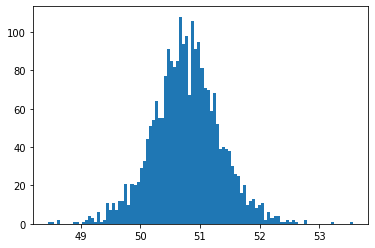

In [48]:
import matplotlib.pyplot as plt
plt.hist(submission_df.tm, bins=100)
plt.show()